#  DATA PROCESSING

In [4]:
#Import of libraries required for visualization, outlier detection, and other components of EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mp

import sklearn
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error

In [5]:
#Read in data from separate text files into individual dataframes
raw_dat_1 = pd.read_fwf('combined_data_1.txt', names=["MovieIDs"])
raw_dat_2 = pd.read_fwf('combined_data_2.txt', names=["MovieIDs"])
raw_dat_3 = pd.read_fwf('combined_data_3.txt', names=["MovieIDs"])
raw_dat_4 = pd.read_fwf('combined_data_4.txt', names=["MovieIDs"])


#Due to the large size of the data, chunking method was used to process each dataframe separately before aggregating

#Process: Split data in each dataframe and explode into separate columns, Populate Movie IDs for each 
#of the Customer IDs using forward filling and then Clean Movie ID data before aggregating into single dataframe

raw_dat_1[['CustomerIDs', 'Rating','Date Watched']] = raw_dat_1['MovieIDs'].str.split(',', expand=True)
raw_dat_1.loc[raw_dat_1['MovieIDs'].str.contains(','),'MovieIDs'] = None
raw_dat_1['MovieIDs'] = raw_dat_1['MovieIDs'].ffill()
raw_dat_1 = raw_dat_1.dropna(subset = ['Date Watched'])
raw_dat_1["MovieIDs"] = raw_dat_1["MovieIDs"].str.strip(':')

print("File 1 complete")

raw_dat_2[['CustomerIDs', 'Rating','Date Watched']] = raw_dat_2['MovieIDs'].str.split(',', expand=True)
raw_dat_2.loc[raw_dat_2['MovieIDs'].str.contains(','),'MovieIDs'] = None
raw_dat_2['MovieIDs'] = raw_dat_2['MovieIDs'].ffill()
raw_dat_2 = raw_dat_2.dropna(subset = ['Date Watched'])
raw_dat_2["MovieIDs"] = raw_dat_2["MovieIDs"].str.strip(':')

print("File 2 complete")

raw_dat_3[['CustomerIDs', 'Rating','Date Watched']] = raw_dat_3['MovieIDs'].str.split(',', expand=True)
raw_dat_3.loc[raw_dat_3['MovieIDs'].str.contains(','),'MovieIDs'] = None
raw_dat_3['MovieIDs'] = raw_dat_3['MovieIDs'].ffill()
raw_dat_3 = raw_dat_3.dropna(subset = ['Date Watched'])
raw_dat_3["MovieIDs"] = raw_dat_3["MovieIDs"].str.strip(':')

print("File 3 complete")

raw_dat_4[['CustomerIDs', 'Rating','Date Watched']] = raw_dat_4['MovieIDs'].str.split(',', expand=True)
raw_dat_4.loc[raw_dat_4['MovieIDs'].str.contains(','),'MovieIDs'] = None
raw_dat_4['MovieIDs'] = raw_dat_4['MovieIDs'].ffill()
raw_dat_4 = raw_dat_4.dropna(subset = ['Date Watched'])
raw_dat_4["MovieIDs"] = raw_dat_4["MovieIDs"].str.strip(':')

print("File 4 complete")

File 1 complete
File 2 complete
File 3 complete
File 4 complete


In [6]:
nflx_raw_data = pd.concat([raw_dat_1, raw_dat_2, raw_dat_3, raw_dat_4], axis=0)
nflx_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100480507 entries, 1 to 26851925
Data columns (total 4 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   MovieIDs      object
 1   CustomerIDs   object
 2   Rating        object
 3   Date Watched  object
dtypes: object(4)
memory usage: 3.7+ GB


In [7]:
nflx_raw_data.to_csv('data.csv')

In [8]:
nflx_raw_data.head()

,MovieIDs,CustomerIDs,Rating,Date Watched
1,1,1488844,3,2005-09-06
2,1,822109,5,2005-05-13
3,1,885013,4,2005-10-19
4,1,30878,4,2005-12-26
5,1,823519,3,2004-05-03


In [9]:
dup_bool = nflx_raw_data.duplicated(['MovieIDs','CustomerIDs','Rating'])
dups = sum(dup_bool) # by considering all columns..( including timestamp)
print("There are {} duplicate rating entries in the data..".format(dups))

There are 0 duplicate rating entries in the data..


# Splitting Train & Test Data

In [10]:

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

In [11]:
if not os.path.isfile('train.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    nflx_raw_data.iloc[:int(nflx_raw_data.shape[0]*0.80)].to_csv("train.csv", index=False)

if not os.path.isfile('test.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    nflx_raw_data.iloc[int(nflx_raw_data.shape[0]*0.80):].to_csv("test.csv", index=False)

train_df = pd.read_csv("train.csv", parse_dates=['Date Watched'])
test_df = pd.read_csv("test.csv")

In [12]:
print("Training data ")
print("-"*50)
print("\nTotal no of ratings :",train_df.shape[0])
print("Total No of Users   :", len(np.unique(train_df.CustomerIDs)))
print("Total No of movies  :", len(np.unique(train_df.MovieIDs)))

Training data 
--------------------------------------------------

Total no of ratings : 80384405
Total No of Users   : 479670
Total No of movies  : 14482


In [13]:
train_df.head()

,MovieIDs,CustomerIDs,Rating,Date Watched
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


## Sparse Matrices

### Train

In [14]:
if os.path.isfile('train_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    train_sparse_matrix = sparse.csr_matrix((train_df.Rating.values, (train_df.CustomerIDs.values,
                                               train_df.MovieIDs.values)),)
    
    print('Done. It\'s shape is : (CustomerIDs, MovieIDs) : ',train_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
    print('Done..\n')

It is present in your pwd, getting it from disk....
DONE..


### Test

In [15]:
if os.path.isfile('test_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    test_sparse_matrix = sparse.csr_matrix((test_df.Rating.values, (test_df.CustomerIDs.values,
                                               test_df.MovieIDs.values)))
    
    print('Done. It\'s shape is : (CustomerIDs, MovieIDs) : ',test_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)
    print('Done..\n')

It is present in your pwd, getting it from disk....
DONE..


## Movie -> Movie Similarity Matrix

In [16]:
if not os.path.isfile('m_m_sim_sparse.npz'):
    print("It seems you don't have that file. Computing movie_movie similarity...")
    m_m_sim_sparse = cosine_similarity(X=train_sparse_matrix.T, dense_output=False)
    print("Done..")
    # store this sparse matrix in disk before using it. For future purposes.
    print("Saving it to disk without the need of re-computing it again.. ")
    sparse.save_npz("m_m_sim_sparse.npz", m_m_sim_sparse)
    print("Done..")
else:
    print("It is there, We will get it.")
    m_m_sim_sparse = sparse.load_npz("m_m_sim_sparse.npz")
    print("Done ...")

print("It's a ",m_m_sim_sparse.shape," dimensional matrix")

It is there, We will get it.
Done ...
It's a  (14483, 14483)  dimensional matrix


In [17]:
movie_ids = np.unique(m_m_sim_sparse.nonzero()[1])

In [18]:
similar_movies = dict()
for movie in movie_ids:
    # get the top similar movies and store them in the dictionary
    sim_movies = m_m_sim_sparse[movie].toarray().ravel().argsort()[::-1][1:]
    similar_movies[movie] = sim_movies[:100]

# just testing similar movies for movie_15
similar_movies[15]

array([ 8279,  8013,  5927, 13105,  4424, 12049, 10193,  4549,  9584,
        5370,   590,  3973,  3755,  6116,  1720,  9071, 10220,  2818,
        9688, 14059,  6349,  4706, 10400,  5865,  9376,  1942,  5929,
       13013,   376,  8003, 10199,  2187,  4513, 11738,   598,  4376,
        8875, 11730,  9166,  9802,  7282, 12762,  1030,   565, 10735,
        2716,  5921, 11947,  7859, 10788,   847, 12700,  2215,  1510,
        9427, 11981, 12954,  6410,  4467,  1690,  8873,  8988,  2429,
       11175,  2399,  7845,  8947,  3706, 13503,  9558,  8218,  5969,
         882,  3502,  9840,  9488,  4649,  5626,  9969, 14275,  9829,
       10319,  3338,  5107,  7481, 11867,  6698, 12905, 12037, 11289,
        4734,  6488,  2879,   218,  1391,  5282,  5871,  3726,  2637,
        7263], dtype=int64)

In [19]:
def manual_separation(bad_line):
    right_split = bad_line[:-2] + [",".join(bad_line[-2:])] # All the "bad lines" where all coming from the same last column that was containing ","
    return right_split

filename = "movie_titles.csv"
movie_titles = pd.read_csv(
        filename, 
        header=None,
        index_col = 'MovieIDs',
        encoding="ISO-8859-1",
        names = ['MovieIDs', 'Date Released', 'Title'], 
        on_bad_lines=manual_separation,
        engine="python",
    )
movie_titles.head()

,Date Released,Title
MovieIDs,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [20]:
mv_id = 67

print("\nMovie ----->",movie_titles.loc[mv_id].values[1])

print("\nIt has {} Ratings from users.".format(train_sparse_matrix[:,mv_id].getnnz()))

print("\nWe have {} movies which are similar to this and we will get only top most..".format(m_m_sim_sparse[:,mv_id].getnnz()))


Movie -----> Vampire Journals

It has 289 Ratings from users.

We have 14464 movies which are similar to this and we will get only top most..


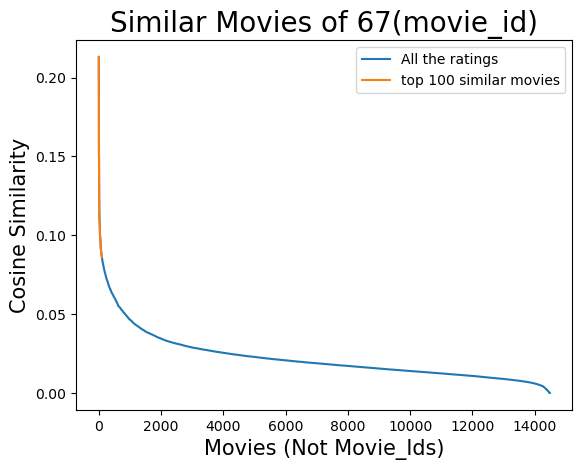

In [21]:
similarities = m_m_sim_sparse[mv_id].toarray().ravel()

similar_indices = similarities.argsort()[::-1][1:]

similarities[similar_indices]

sim_indices = similarities.argsort()[::-1][1:] # It will sort and reverse the array and ignore its similarity (ie.,1)
                                               # and return its indices(movie_ids)

plt.plot(similarities[sim_indices], label='All the ratings')
plt.plot(similarities[sim_indices[:100]], label='top 100 similar movies')
plt.title("Similar Movies of {}(movie_id)".format(mv_id), fontsize=20)
plt.xlabel("Movies (Not Movie_Ids)", fontsize=15)
plt.ylabel("Cosine Similarity",fontsize=15)
plt.legend()
plt.show()

In [22]:
movie_titles.loc[sim_indices[:10]]

,Date Released,Title
MovieIDs,,
323,1999.0,Modern Vampires
4044,1998.0,Subspecies 4: Bloodstorm
1688,1993.0,To Sleep With a Vampire
4667,1996.0,Vampirella
13962,2001.0,Dracula: The Dark Prince
12053,1993.0,Dracula Rising
13873,2001.0,The Breed
1900,1997.0,Club Vampire
7573,2000.0,Kindred: The Embraced: The Complete Vampire Co...


## Building Model

In [23]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):
    """
        It will get it from the ''path'' if it is present  or It will create 
        and store the sampled sparse matrix in the path specified.
    """

    # get (row, col) and (rating) tuple from sparse_matrix...
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

    # It just to make sure to get same sample everytime we run this program..
    # and pick without replacement....
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    # get the boolean mask or these sampled_items in originl row/col_inds..
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Done..\n')
    
    return sample_sparse_matrix

### Sample Train & Test Data

In [24]:
path = "sample/small/sample_train_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_train_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else: 
    # get 10k users and 1k movies from available data 
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=10000, no_movies=1000,
                                             path = path)

It is present in your pwd, getting it from disk....
DONE..


In [25]:
path = "sample/small/sample_test_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_test_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else:
    # get 5k users and 500 movies from available data 
    sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=5000, no_movies=500,
                                                 path = "sample/small/sample_test_sparse_matrix.npz")

It is present in your pwd, getting it from disk....
DONE..


In [26]:
# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)

def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

In [27]:
sample_train_averages = dict()

# get the global average of ratings in our train set.
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
sample_train_averages

{'global': 3.578980718747171}

In [28]:
# avg rating per user
sample_train_averages['user'] = get_average_ratings(sample_train_sparse_matrix, of_users=True)
print('\nAverage rating of user 364709 :',sample_train_averages['user'][364709])

# avg rating per movie
sample_train_averages['movie'] =  get_average_ratings(sample_train_sparse_matrix, of_users=False)
print('\nAverage rating of movie 12248 :',sample_train_averages['movie'][12248])


Average rating of user 364709 : 4.428571428571429

Average rating of movie 12248 : 3.16


## Data Featurization

In [29]:
print('\n No of ratings in Our Sampled train matrix is : {}\n'.format(sample_train_sparse_matrix.count_nonzero()))
print('\n No of ratings in Our Sampled test  matrix is : {}\n'.format(sample_test_sparse_matrix.count_nonzero()))


 No of ratings in Our Sampled train matrix is : 132564


 No of ratings in Our Sampled test  matrix is : 31333



### Training Data

In [30]:
# get users, movies and ratings from our samples train sparse matrix
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

In [31]:
if os.path.isfile('sample/small/reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open('sample/small/reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(sample_train_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(sample_train_averages['user'][user])
            # Avg_movie rating
            row.append(sample_train_averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                print("Done for {} rows-----".format(count))


File already exists you don't have to prepare again...


In [32]:
reg_train = pd.read_csv('sample/small/reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,1876156,7,3.578981,1.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,3.0,3.0,3.058140,1.000000,1
1,15992,18,3.578981,4.0,4.0,5.0,4.0,3.0,3.0,3.0,5.0,3.0,1.0,3.227273,3.840517,4
2,16833,18,3.578981,3.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,5.0,4.0,3.794872,3.840517,4
3,41840,18,3.578981,4.0,4.0,5.0,5.0,5.0,3.0,4.0,2.0,3.0,5.0,3.750000,3.840517,5
4,50259,18,3.578981,3.0,2.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,2.0,3.466667,3.840517,3


- GAvg : Average rating of all the ratings

- Similar users rating of this movie:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 similar users who rated that movie.. )

- Similar movies rated by this user:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 similar movies rated by this movie.. )

- UAvg : User's Average rating

- MAvg : Average rating of this movie

- rating : Rating of this movie by this user

### Testing Data

In [33]:
# get users, movies and ratings from the Sampled Test 
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [34]:
sample_train_averages['global']

3.578980718747171

In [35]:
if os.path.isfile('sample/small/reg_test.csv'):
    print("It is already created...")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('sample/small/reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
        #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            try:
                # compute the similar Users of the "user"        
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar users for this movie
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                # we will make it's length "5" by adding movie averages to .
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                # print(top_sim_users_ratings, end="--")

            except (IndexError, KeyError):
                # It is a new User or new Movie or there are no ratings for given user for top similar movies...
                ########## Cold STart Problem ##########
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
            except:
                print(user, movie)
                # we just want KeyErrors to be resolved. Not every Exception...
                raise



            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try:
                # compute the similar movies of the "movie"        
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar movie rated by this user..
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                # we will make it's length "5" by adding user averages to.
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
                #print(top_sim_movies_ratings)
            except (IndexError, KeyError):
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # add usser and movie name first
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global']) # first feature
            #print(row)
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            #print(row)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            #print(row)
            # Avg_user rating
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # Avg_movie rating
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            #print(row)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            #print(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                #print(','.join(map(str, row)))
                print("Done for {} rows-----".format(count))

It is already created...


In [36]:
reg_test_df = pd.read_csv('sample/small/reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,2480278,14485,3.578981,1,3,1,4,2.2,4,2,2,3,4,3.578981,3.578981,1
1,699732,14499,3.578981,1,3,1,4,2.2,4,2,2,3,4,3.578981,3.578981,4
2,440463,14500,3.578981,1,3,1,4,2.2,4,2,2,3,4,3.578981,3.578981,3
3,467182,14500,3.578981,1,3,1,4,2.2,4,2,2,3,4,3.578981,3.578981,3


- GAvg : Average rating of all the ratings

- Similar users rating of this movie:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 similar users who rated that movie.. )

- Similar movies rated by this user:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 similar movies rated by this movie.. )

- UAvg : User's Average rating

- MAvg : Average rating of this movie

- rating : Rating of this movie by this user

### Prepping Trainset & Testset Data

In [37]:
from surprise import Reader, Dataset

In [38]:
# It is to specify how to read the dataframe.
# for our dataframe, we don't have to specify anything extra..
reader = Reader(rating_scale=(1,5))

# create the traindata from the dataframe...
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
trainset = train_data.build_full_trainset() 

In [39]:
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:3]

[(2480278, 14485, 1), (699732, 14499, 4), (440463, 14500, 3)]

In [40]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

### Helper Funcs

In [41]:
# to get rmse and mape given actual and predicted ratings..
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

###################################################################
###################################################################
def run_xgboost(algo,  x_train, y_train, x_test, y_test, verbose=True):
    """
    It will return train_results and test_results
    """
    
    # dictionaries for storing train and test results
    train_results = dict()
    test_results = dict()
    
    
    # fit the model
    print('Training the model..')
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Done.')
    print('Done \n')

    # from the trained model, get the predictions....
    print('Evaluating the model with TRAIN data...')
    y_train_pred = algo.predict(x_train)
    # get the rmse and mape of train data...
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
    # store the results in train_results dictionary..
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
    
    #######################################
    # get the test data predictions and compute rmse and mape
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    # store them in our test results dictionary.
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    # return these train and test results...
    return train_results, test_results

In [42]:
# it is just to makesure that all of our algorithms should produce same results
# everytime they run...

my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

##########################################################
# get  (actual_list , predicted_list) ratings given list 
# of predictions (prediction is a class in Surprise).    
##########################################################
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

################################################################
# get ''rmse'' and ''mape'' , given list of prediction objecs 
################################################################
def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

##################################################################################
# It will return predicted ratings, rmse and mape of both train and test data   #
##################################################################################
def run_surprise(algo, trainset, testset, verbose=True): 
    '''
        return train_dict, test_dict
    
        It returns two dictionaries, one for train and the other is for test
        Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted ratings''.
    '''
    # dictionaries that stores metrics for train and test..
    train = dict()
    test = dict()
    
    # train the algorithm with the trainset
    print('Training the model...')
    algo.fit(trainset)
    print('Done.\n')
    
    # ---------------- Evaluating train data--------------------#
    print('Evaluating the model with train data..')
    # get the train predictions (list of prediction class inside Surprise)
    train_preds = algo.test(trainset.build_testset())
    # get predicted ratings from the train predictions..
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    # get ''rmse'' and ''mape'' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    #store them in the train dictionary
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#
    print('\nEvaluating for test data...')
    # get the predictions( list of prediction classes) of test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
        
    # return two dictionaries train and test
    return train, test

## Comparing SVD vs SVDpp predictions

In [43]:
from surprise import SVD

In [45]:
# initiallize the model
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation data structure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Done.

Evaluating the model with train data..
---------------
Train Data
---------------
RMSE : 0.6530133620026428

MAPE : 19.698665404330058

adding train results in the dictionary..

Evaluating for test data...
---------------
Test Data
---------------
RMSE : 1.0790831594706038

MAPE : 35.34663079259673

storing the test results in test dictionary...

---------------------------------------------


In [46]:
from surprise import SVDpp

In [73]:
# initiallize the model
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp'] = svdpp_test_results

Training the model...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Done.

Evaluating the model with train data..
---------------
Train Data
---------------
RMSE : 0.6067628499468557

MAPE : 17.785628472201314

adding train results in the dictionary..

Evaluating for test data...
---------------
Test Data
---------------
RMSE : 1.0791701368588202

MAPE : 35.34441064239917

storing the test results in test dictionary...

---------------------------------------------


- **SVDpp** -> Lower train RMSE but higher test RMSE indicates overfitting
- **SVD** -> Higher train RMSE but lower test RMSE

## SVD Optimization

In [74]:
from surprise.model_selection import GridSearchCV

In [79]:
param_grid = {
    "n_epochs": [5, 10, 20, 25, 30],
    "lr_all": [0.002, 0.003, 0.004, 0.005, 0.006, 0.007],
    "reg_all": [0.01, 0.02, 0.03, 0.2, 0.4]
}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)

gs.fit(train_data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

0.9585820201001125
{'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.03}


In [82]:
# Re-run with new reg_all
svd = SVD(reg_all=0.03, n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation data structure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Done.

Evaluating the model with train data..
---------------
Train Data
---------------
RMSE : 0.7150906503923977

MAPE : 21.831011377784616

adding train results in the dictionary..

Evaluating for test data...
---------------
Test Data
---------------
RMSE : 1.0790656036655348

MAPE : 35.346417494271435

storing the test results in test dictionary...

---------------------------------------------


- A bit higher train RMSE but lower test RMSE
- A bit higher train MAPE but not much higher test MAPE
- Result: More optimized model, but only slightly

In [86]:
svd.predict(2372045,14501)

Prediction(uid=2372045, iid=14501, r_ui=None, est=3.578980718747171, details={'was_impossible': False})